# 0. Libraries and importing the data

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

We import the training and the test data:

In [33]:
# We import the training dataset
df_og = pd.read_csv('../train.csv')

# We create a copy of the original dataset, so that we do not have to load the dataset
# again if we want to go back to the original one
df = df_og.copy()

# We import the training dataset
dft_og = pd.read_csv('../test.csv')

# We create a copy of the original dataset, so that we do not have to load the dataset
# again if we want to go back to the original one
dft = dft_og.copy()

In [34]:
# First, we reorder the dataframe and assign some prefixes to the positions
# so that it is easier to catch specific patterns

# Mapping positions to their groups
group_mapping = {
    'Goalkeeper': ['GK'],
    'Defenders': ['CB', 'LCB', 'RCB', 'LB', 'RB', 'LWB', 'RWB'],
    'Midfielders': ['CDM', 'LDM', 'RDM', 'CM', 'LCM', 'RCM', 'CAM', 'LM', 'RM'],
    'Attackers': ['ST', 'RS', 'LS', 'LF', 'RF', 'RW', 'LW']
}

# Prefix mappings
prefix_mapping = {
    'Goalkeeper': 'G_',
    'Defenders': 'D_',
    'Midfielders': 'M_',
    'Attackers': 'A_'
}

# Flatten mapping to find the group for each position
position_to_group = {pos: group for group, positions in group_mapping.items() for pos in positions}

# Adding a prefix to position names
df['position_grouped'] = df['position'].map(lambda x: prefix_mapping[position_to_group[x]] + x)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6895 entries, 0 to 6894
Data columns (total 71 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           6895 non-null   int64  
 1   short_name                   6895 non-null   object 
 2   overall                      6895 non-null   int64  
 3   potential                    6895 non-null   int64  
 4   value_eur                    6893 non-null   float64
 5   wage_eur                     6895 non-null   int64  
 6   birthday_date                6895 non-null   object 
 7   height_cm                    6895 non-null   int64  
 8   weight_kg                    6895 non-null   int64  
 9   club_name                    6895 non-null   object 
 10  league_name                  6895 non-null   object 
 11  league_level                 6895 non-null   int64  
 12  club_jersey_number           6895 non-null   int64  
 13  club_loaned_from  

Remaining features:

In [63]:
# List of numerical features (45 in total)
numerical_features = [
    'overall', 'potential', 'wage_eur', 'height_cm', 'weight_kg',
    'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys',
    'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
    'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance',
    'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
    'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
    'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle',
    'value_eur', 'release_clause_eur', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 
    'physic', 'age', 'height_weight_ratio'
]

# List of date features (1 in total)
date_features = ['club_contract_valid_until']

# List of categorical ordinal features (5 in total)
categorical_ordinal_features = [
    'league_level', 'weak_foot', 'skill_moves', 'international_reputation', 'work_rate'
]

# List of categorical nominal features (18 in total)
categorical_nominal_features = [
    'club_jersey_number', 'short_name', 'club_name', 
    'nationality_name', 'preferred_foot_Right',	
    'preferred_foot_Left', 'real_face_Yes', 'real_face_No',
    'work_rate_High/High', 'work_rate_High/Low', 'work_rate_High/Medium',
    'work_rate_Low/High', 'work_rate_Low/Low', 'work_rate_Low/Medium',
    'work_rate_Medium/High', 'work_rate_Medium/Low',
    'work_rate_Medium/Medium', 'league_country'
]

# Complete list of categorical features
categorical_features = categorical_nominal_features + categorical_ordinal_features

# From the list of categorical features, we only keep those for which the visualization makes sense
# (i.e., they have a low enough number of distinct values)
categorical_features_eda = categorical_ordinal_features + ['preferred_foot', 'body_type']

# 2. Preprocessing

## 2.1. Feature creation
Create features that may be useful for improving the predictions (before splitting the data *in case that feature creation is NOT done taking into consideration the specific values of the dataset*). Features created/replaced, for now (for more suggestions, refer to the EDA notebook):
- Replace *league_name* with the country of the league: that way, together with *league_level*, information will be more efficient.
- Replace *body_type* with the ratio of height and weight, and we keep both variables separately. That way, our model will have a more readable feature, while also keeping the granularity of keeping height and weight separately.
- For dealing with dates more easily, we can convert the features *club_joined* and *birthday_date* to the number of months since a player joined a club and the age in years, respectively. Then, we can drop the other features.

**Also, we have to consider that there might be different unique values in the test set than in the training set, so the feature creation in these cases must be done with the training and the test set together!**

In [37]:
# Combine train and test datasets. We will use this dataset to create features
# that depend on the unique values of categories (such as league_name)
df_combined = pd.concat([df, dft], ignore_index=True)

### Replacing *league_name* with *league_country*

In [38]:
# List of unique league_name
print(df_combined.league_name.unique())
print(df_combined.league_name.nunique())

['Mexican Liga MX' 'Scottish Premiership' 'Danish Superliga'
 'Korean K League 1' 'Romanian Liga I' 'Peruvian Primera División'
 'German 1. Bundesliga' 'Chinese Super League'
 'Belgian Jupiler Pro League' 'English Premier League'
 'German 2. Bundesliga' 'French Ligue 2' 'Argentina Primera División'
 'Paraguayan Primera División' 'Liga de Fútbol Profesional Boliviano'
 'Swedish Allsvenskan' 'Spanish Segunda División'
 'English League Championship' 'Turkish Süper Lig' 'Norwegian Eliteserien'
 'Polish T-Mobile Ekstraklasa' 'Japanese J. League Division 1'
 'German 3. Bundesliga' 'Campeonato Brasileiro Série A'
 'English National League' 'USA Major League Soccer'
 'Colombian Liga Postobón' 'Austrian Football Bundesliga'
 'English League One' 'Saudi Abdul L. Jameel League' 'French Ligue 1'
 'Hungarian Nemzeti Bajnokság I' 'Italian Serie A'
 'Spain Primera Division' 'English League Two'
 'Portuguese Liga ZON SAGRES' 'Australian Hyundai A-League'
 'Ecuadorian Serie A' 'Holland Eredivisie' 'Chi

In [39]:
# We create a map for the league with the corresponding country
league_to_country = {
    'Mexican Liga MX': 'Mexico',
    'Scottish Premiership': 'Scotland',
    'Danish Superliga': 'Denmark',
    'Korean K League 1': 'South Korea',
    'Romanian Liga I': 'Romania',
    'Peruvian Primera División': 'Peru',
    'German 1. Bundesliga': 'Germany',
    'Chinese Super League': 'China',
    'Belgian Jupiler Pro League': 'Belgium',
    'English Premier League': 'England',
    'German 2. Bundesliga': 'Germany',
    'French Ligue 2': 'France',
    'Argentina Primera División': 'Argentina',
    'Paraguayan Primera División': 'Paraguay',
    'Liga de Fútbol Profesional Boliviano': 'Bolivia',
    'Swedish Allsvenskan': 'Sweden',
    'Spanish Segunda División': 'Spain',
    'English League Championship': 'England',
    'Turkish Süper Lig': 'Turkey',
    'Norwegian Eliteserien': 'Norway',
    'Polish T-Mobile Ekstraklasa': 'Poland',
    'Japanese J. League Division 1': 'Japan',
    'German 3. Bundesliga': 'Germany',
    'Campeonato Brasileiro Série A': 'Brazil',
    'English National League': 'England',
    'USA Major League Soccer': 'USA',
    'Colombian Liga Postobón': 'Colombia',
    'Austrian Football Bundesliga': 'Austria',
    'English League One': 'England',
    'Saudi Abdul L. Jameel League': 'Saudi Arabia',
    'French Ligue 1': 'France',
    'Hungarian Nemzeti Bajnokság I': 'Hungary',
    'Italian Serie A': 'Italy',
    'Spain Primera Division': 'Spain',
    'English League Two': 'England',
    'Portuguese Liga ZON SAGRES': 'Portugal',
    'Australian Hyundai A-League': 'Australia',
    'Ecuadorian Serie A': 'Ecuador',
    'Holland Eredivisie': 'Netherlands',
    'Chilian Campeonato Nacional': 'Chile',
    'Rep. Ireland Airtricity League': 'Ireland',
    'Czech Republic Gambrinus Liga': 'Czech Republic',
    'South African Premier Division': 'South Africa',
    'Greek Super League': 'Greece',
    'Russian Premier League': 'Russia',
    'Indian Super League': 'India',
    'Italian Serie B': 'Italy',
    'Swiss Super League': 'Switzerland',
    'Venezuelan Primera División': 'Venezuela',
    'Uruguayan Primera División': 'Uruguay',
    'Ukrainian Premier League': 'Ukraine',
    'UAE Arabian Gulf League': 'UAE',
    'Croatian Prva HNL': 'Croatia',
    'Finnish Veikkausliiga': 'Finland',
    'Cypriot First Division': 'Cyprus'
}

# We create a copy of the training and test datasets
df_league = df.copy()
dft_league = dft.copy()

# We map the league_names with the country and remove the original column, in both
# the training and test datasets
df_league['league_country'] = df_league['league_name'].map(league_to_country)
dft_league['league_country'] = dft_league['league_name'].map(league_to_country)

# Drop the original league_name column
df_league.drop(columns=['league_name'], inplace=True)
dft_league.drop(columns=['league_name'], inplace=True)

In [40]:
df_league

,id,short_name,overall,potential,value_eur,wage_eur,birthday_date,height_cm,weight_kg,club_name,...,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,position,position_grouped,league_country
0,216302,E. García,71,71,1400000.0,10000,1989-12-28,176,73,Club Atlético de San Luis,...,65,14,11,12,12,12,NaN,LB,D_LB,Mexico
1,237867,D. Cancola,65,71,1000000.0,2000,1996-10-23,183,73,Ross County FC,...,58,10,13,7,6,11,NaN,LDM,M_LDM,Scotland
2,253472,E. Kahl,65,77,1600000.0,2000,2001-09-27,178,69,Aarhus GF,...,59,10,10,8,10,11,NaN,LWB,D_LWB,Denmark
3,223994,S. Mugoša,72,72,2300000.0,5000,1992-02-26,188,81,Incheon United FC,...,19,16,15,13,8,9,NaN,LS,A_LS,South Korea
4,251635,A. Țigănașu,65,65,525000.0,3000,1990-06-12,179,74,FC Botoşani,...,58,12,5,11,12,15,NaN,LB,D_LB,Romania
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6890,242007,C. Whelan,59,66,425000.0,2000,1997-12-10,180,65,Carlisle United,...,58,12,9,10,8,13,NaN,RCB,D_RCB,England
6891,187961,Paulinho,83,83,28500000.0,61000,1988-07-25,183,80,Al Ahli,...,75,16,16,11,6,8,NaN,LCM,M_LCM,Saudi Arabia
6892,257234,Y. Hamache,70,80,3400000.0,6000,1999-07-13,177,73,Boavista FC,...,68,8,9,5,8,10,NaN,LWB,D_LWB,Portugal
6893,232511,S. Sasaki,71,71,1300000.0,7000,1989-10-02,176,70,Sanfrecce Hiroshima,...,70,8,10,10,10,8,NaN,LCB,D_LCB,Japan


We have to update the list of feature names with this new feature (see the beginning of the notebook).

### Replacing *body_type* with *height_weight_ratio*

In [41]:
df_btype = df_league.copy()
dft_btype = dft_league.copy()

# We create the height-weight ratio feature
## Training
df_btype['height_weight_ratio'] = df_btype['height_cm'] / df_btype['weight_kg']
## Test
dft_btype['height_weight_ratio'] = dft_btype['height_cm'] / dft_btype['weight_kg']

# we drop the body_type feature
## Training
df_btype.drop(columns=['body_type'], inplace=True)
## Test
dft_btype.drop(columns=['body_type'], inplace=True)

In [42]:
df_btype

,id,short_name,overall,potential,value_eur,wage_eur,birthday_date,height_cm,weight_kg,club_name,...,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,position,position_grouped,league_country,height_weight_ratio
0,216302,E. García,71,71,1400000.0,10000,1989-12-28,176,73,Club Atlético de San Luis,...,14,11,12,12,12,NaN,LB,D_LB,Mexico,2.410959
1,237867,D. Cancola,65,71,1000000.0,2000,1996-10-23,183,73,Ross County FC,...,10,13,7,6,11,NaN,LDM,M_LDM,Scotland,2.506849
2,253472,E. Kahl,65,77,1600000.0,2000,2001-09-27,178,69,Aarhus GF,...,10,10,8,10,11,NaN,LWB,D_LWB,Denmark,2.579710
3,223994,S. Mugoša,72,72,2300000.0,5000,1992-02-26,188,81,Incheon United FC,...,16,15,13,8,9,NaN,LS,A_LS,South Korea,2.320988
4,251635,A. Țigănașu,65,65,525000.0,3000,1990-06-12,179,74,FC Botoşani,...,12,5,11,12,15,NaN,LB,D_LB,Romania,2.418919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6890,242007,C. Whelan,59,66,425000.0,2000,1997-12-10,180,65,Carlisle United,...,12,9,10,8,13,NaN,RCB,D_RCB,England,2.769231
6891,187961,Paulinho,83,83,28500000.0,61000,1988-07-25,183,80,Al Ahli,...,16,16,11,6,8,NaN,LCM,M_LCM,Saudi Arabia,2.287500
6892,257234,Y. Hamache,70,80,3400000.0,6000,1999-07-13,177,73,Boavista FC,...,8,9,5,8,10,NaN,LWB,D_LWB,Portugal,2.424658
6893,232511,S. Sasaki,71,71,1300000.0,7000,1989-10-02,176,70,Sanfrecce Hiroshima,...,8,10,10,10,8,NaN,LCB,D_LCB,Japan,2.514286


We have to update the list of feature names with this new feature (see the beginning of the notebook).

### Replacing date variables *club_joined* and *birthday_date*
To the number of months since a player joined a club and the age in years, respectively. Then, we can drop the other features. As a reference date for doing these computations, we can check what is the last date when a player joined a club - if it is in the end of 2022, for instance, then we can take the end of 2022 as the reference date.

In [43]:
df_dates = df_btype.copy()
dft_dates = dft_btype.copy()

# Convert columns to datetime
## Training
df_dates['club_joined'] = pd.to_datetime(df_dates['club_joined'], format='%Y-%m-%d')
df_dates['birthday_date'] = pd.to_datetime(df_dates['birthday_date'], format='%Y-%m-%d')
## Test
dft_dates['club_joined'] = pd.to_datetime(dft_dates['club_joined'], format='%Y-%m-%d')
dft_dates['birthday_date'] = pd.to_datetime(dft_dates['birthday_date'], format='%Y-%m-%d')
## Combined (only the club_joined is needed for determining the reference date)
df_combined['club_joined'] = pd.to_datetime(df_combined['club_joined'], format='%Y-%m-%d')

# Determine the reference date (latest club_joined date)
reference_date = df_combined['club_joined'].max()

# Compute months since club_joined
## Training
df_dates['months_since_joined'] = (reference_date.year - df_dates['club_joined'].dt.year) * 12 + (reference_date.month - df_dates['club_joined'].dt.month)
## Test
dft_dates['months_since_joined'] = (reference_date.year - dft_dates['club_joined'].dt.year) * 12 + (reference_date.month - dft_dates['club_joined'].dt.month)

# Compute age in years, adjusting if the player's birthday has not occurred yet
## Training
df_dates['age'] = reference_date.year - df_dates['birthday_date'].dt.year - (
    (reference_date.month * 100 + reference_date.day) < (df_dates['birthday_date'].dt.month * 100 + df_dates['birthday_date'].dt.day)
)
## Test
dft_dates['age'] = reference_date.year - dft_dates['birthday_date'].dt.year - (
    (reference_date.month * 100 + reference_date.day) < (dft_dates['birthday_date'].dt.month * 100 + dft_dates['birthday_date'].dt.day)
)

# Drop the original date columns
## Training
df_dates.drop(columns=['club_joined', 'birthday_date'], inplace=True)
## Test
dft_dates.drop(columns=['club_joined', 'birthday_date'], inplace=True)

In [44]:
df_dates

,id,short_name,overall,potential,value_eur,wage_eur,height_cm,weight_kg,club_name,league_level,...,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,position,position_grouped,league_country,height_weight_ratio,months_since_joined,age
0,216302,E. García,71,71,1400000.0,10000,176,73,Club Atlético de San Luis,1,...,12,12,12,NaN,LB,D_LB,Mexico,2.410959,2.0,31
1,237867,D. Cancola,65,71,1000000.0,2000,183,73,Ross County FC,1,...,7,6,11,NaN,LDM,M_LDM,Scotland,2.506849,2.0,24
2,253472,E. Kahl,65,77,1600000.0,2000,178,69,Aarhus GF,1,...,8,10,11,NaN,LWB,D_LWB,Denmark,2.579710,2.0,19
3,223994,S. Mugoša,72,72,2300000.0,5000,188,81,Incheon United FC,1,...,13,8,9,NaN,LS,A_LS,South Korea,2.320988,43.0,29
4,251635,A. Țigănașu,65,65,525000.0,3000,179,74,FC Botoşani,1,...,11,12,15,NaN,LB,D_LB,Romania,2.418919,26.0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6890,242007,C. Whelan,59,66,425000.0,2000,180,65,Carlisle United,4,...,10,8,13,NaN,RCB,D_RCB,England,2.769231,2.0,23
6891,187961,Paulinho,83,83,28500000.0,61000,183,80,Al Ahli,1,...,11,6,8,NaN,LCM,M_LCM,Saudi Arabia,2.287500,2.0,33
6892,257234,Y. Hamache,70,80,3400000.0,6000,177,73,Boavista FC,1,...,5,8,10,NaN,LWB,D_LWB,Portugal,2.424658,13.0,22
6893,232511,S. Sasaki,71,71,1300000.0,7000,176,70,Sanfrecce Hiroshima,1,...,10,10,8,NaN,LCB,D_LCB,Japan,2.514286,80.0,31


We can now treat these new features as numerical variables, so we need to update the lists of feature names (see the beginning of the notebook).

## 2.2. Feature removal
For now, the following features will be removed from the dataset.
- All goalkeeping variables, including *goalkeeping_speed*, since by predicting that the observations with values in *pace, shooting, passing, dribbling, defending* or *physic* will belong to the goalkeeper class.
- Also, for now we will delete the variables *player_tags* (which has an excessive number of missing values and for which the imputation will be very inaccurate, see EDA) and *player_traits*, which might be a good predictor if correctly treated (e.g., finding the unique traits and OHE those) but it may take significant time.

### Goalkeeping variables

In [45]:
df_gk = df_dates.copy()
dft_gk = dft_dates.copy()

# Drop the goalkeeper columns
## Training
df_gk.drop(columns=[
    'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed'
    ], inplace=True)
## Test
dft_gk.drop(columns=[
    'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed'
    ], inplace=True)

In [46]:
df_gk

,id,short_name,overall,potential,value_eur,wage_eur,height_cm,weight_kg,club_name,league_level,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,position,position_grouped,league_country,height_weight_ratio,months_since_joined,age
0,216302,E. García,71,71,1400000.0,10000,176,73,Club Atlético de San Luis,1,...,66,65,66,65,LB,D_LB,Mexico,2.410959,2.0,31
1,237867,D. Cancola,65,71,1000000.0,2000,183,73,Ross County FC,1,...,59,65,61,58,LDM,M_LDM,Scotland,2.506849,2.0,24
2,253472,E. Kahl,65,77,1600000.0,2000,178,69,Aarhus GF,1,...,65,60,58,59,LWB,D_LWB,Denmark,2.579710,2.0,19
3,223994,S. Mugoša,72,72,2300000.0,5000,188,81,Incheon United FC,1,...,75,16,22,19,LS,A_LS,South Korea,2.320988,43.0,29
4,251635,A. Țigănașu,65,65,525000.0,3000,179,74,FC Botoşani,1,...,58,64,61,58,LB,D_LB,Romania,2.418919,26.0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6890,242007,C. Whelan,59,66,425000.0,2000,180,65,Carlisle United,4,...,45,52,57,58,RCB,D_RCB,England,2.769231,2.0,23
6891,187961,Paulinho,83,83,28500000.0,61000,183,80,Al Ahli,1,...,81,80,79,75,LCM,M_LCM,Saudi Arabia,2.287500,2.0,33
6892,257234,Y. Hamache,70,80,3400000.0,6000,177,73,Boavista FC,1,...,62,62,67,68,LWB,D_LWB,Portugal,2.424658,13.0,22
6893,232511,S. Sasaki,71,71,1300000.0,7000,176,70,Sanfrecce Hiroshima,1,...,60,72,72,70,LCB,D_LCB,Japan,2.514286,80.0,31


We have to update the list of feature names with this new feature removal (see the beginning of the notebook).

### *player_tags* and *player_traits*

In [47]:
df_notext = df_gk.copy()
dft_notext = dft_gk.copy()

# Drop the tags and traits columns
## Training
df_notext.drop(columns=['player_tags', 'player_traits'], inplace=True)
## Test
dft_notext.drop(columns=['player_tags', 'player_traits'], inplace=True)

In [48]:
df_notext

,id,short_name,overall,potential,value_eur,wage_eur,height_cm,weight_kg,club_name,league_level,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,position,position_grouped,league_country,height_weight_ratio,months_since_joined,age
0,216302,E. García,71,71,1400000.0,10000,176,73,Club Atlético de San Luis,1,...,66,65,66,65,LB,D_LB,Mexico,2.410959,2.0,31
1,237867,D. Cancola,65,71,1000000.0,2000,183,73,Ross County FC,1,...,59,65,61,58,LDM,M_LDM,Scotland,2.506849,2.0,24
2,253472,E. Kahl,65,77,1600000.0,2000,178,69,Aarhus GF,1,...,65,60,58,59,LWB,D_LWB,Denmark,2.579710,2.0,19
3,223994,S. Mugoša,72,72,2300000.0,5000,188,81,Incheon United FC,1,...,75,16,22,19,LS,A_LS,South Korea,2.320988,43.0,29
4,251635,A. Țigănașu,65,65,525000.0,3000,179,74,FC Botoşani,1,...,58,64,61,58,LB,D_LB,Romania,2.418919,26.0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6890,242007,C. Whelan,59,66,425000.0,2000,180,65,Carlisle United,4,...,45,52,57,58,RCB,D_RCB,England,2.769231,2.0,23
6891,187961,Paulinho,83,83,28500000.0,61000,183,80,Al Ahli,1,...,81,80,79,75,LCM,M_LCM,Saudi Arabia,2.287500,2.0,33
6892,257234,Y. Hamache,70,80,3400000.0,6000,177,73,Boavista FC,1,...,62,62,67,68,LWB,D_LWB,Portugal,2.424658,13.0,22
6893,232511,S. Sasaki,71,71,1300000.0,7000,176,70,Sanfrecce Hiroshima,1,...,60,72,72,70,LCB,D_LCB,Japan,2.514286,80.0,31


We have to update the list of feature names with this new feature removal (see the beginning of the notebook).

## 2.3. Dealing with categorical variables
In this section, we apply:
- OHE to categorical features relevant for prediction - those which don't have a very large number of distinct values (so only *preferred_foot*, *real_face* and *work_rate*).
- Ordinal encoding for all ordinal categorical features that are not already encoded (in fact, all of these features are already encoded).
- Label encoding to the features with a large number of categories, such as those related to the jersey number (*club_jersey_number* and *nation_jersey_number*) and *league_country*, *nationality_name*.

The same transformation can be applied to the test set without having data leakage.

### OHE
Applied to categorical features relevant for prediction - those which don't have a very large number of distinct values (so only *preferred_foot*, *real_face* and *work_rate*). Since there are no missing values in either of these variables, we can apply OHE directly to the training and test sets, before even splitting the training dataset into training-validation (as no imputation will be needed for these columns).

In [49]:
def ohe_join(dataframe: pd.DataFrame, variables_to_encode: list, na_column: bool, drop_first: bool):
    for column in variables_to_encode:
        # We encode OHE each variable, creating an additional column which stores NaN
        ohe = pd.get_dummies(data = dataframe[column], drop_first = drop_first, dummy_na = na_column)
        
        # Rename columns to avoid potential conflicts
        ohe.columns = [f"{column}_{str(col)}" for col in ohe.columns]
        
        # Join the encoded variable to the input dataframe
        dataframe = dataframe.join(ohe)
        
        # Drop the original variable from the dataframe
        dataframe = dataframe.drop(labels=column, axis=1)
    
    return dataframe

In [50]:
# We create copies of the datasets
df_ohe = df_notext.copy()
dft_ohe = dft_notext.copy()

# Combine train and test datasets
df_combined_ohe = pd.concat([df_ohe, dft_ohe], ignore_index=True)

# We apply OHE to the combined dataset
df_combined_ohe = ohe_join(
    dataframe = df_combined_ohe, 
    variables_to_encode = ['preferred_foot', 'real_face', 'work_rate'], 
    na_column = False,
    drop_first = False)

# Separate the combined dataset back into training and test datasets
df_ohe = df_combined_ohe.iloc[:len(df)].reset_index(drop=True)
dft_ohe = df_combined_ohe.iloc[len(df):].reset_index(drop=True)

In [51]:
df_ohe

,id,short_name,overall,potential,value_eur,wage_eur,height_cm,weight_kg,club_name,league_level,...,real_face_Yes,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium
0,216302,E. García,71,71,1400000.0,10000,176,73,Club Atlético de San Luis,1,...,False,False,False,False,False,False,False,True,False,False
1,237867,D. Cancola,65,71,1000000.0,2000,183,73,Ross County FC,1,...,False,False,False,False,False,False,False,False,False,True
2,253472,E. Kahl,65,77,1600000.0,2000,178,69,Aarhus GF,1,...,False,False,False,True,False,False,False,False,False,False
3,223994,S. Mugoša,72,72,2300000.0,5000,188,81,Incheon United FC,1,...,False,False,False,True,False,False,False,False,False,False
4,251635,A. Țigănașu,65,65,525000.0,3000,179,74,FC Botoşani,1,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6890,242007,C. Whelan,59,66,425000.0,2000,180,65,Carlisle United,4,...,False,False,False,False,False,False,False,False,False,True
6891,187961,Paulinho,83,83,28500000.0,61000,183,80,Al Ahli,1,...,True,True,False,False,False,False,False,False,False,False
6892,257234,Y. Hamache,70,80,3400000.0,6000,177,73,Boavista FC,1,...,False,False,False,True,False,False,False,False,False,False
6893,232511,S. Sasaki,71,71,1300000.0,7000,176,70,Sanfrecce Hiroshima,1,...,False,False,False,False,False,False,False,True,False,False


We have to update the list of feature names with this new feature removal (see the beginning of the notebook). For now, we have not dropped any dummy, but for some models (such as KNN or logistic regression) dropping one dummy is needed for avoiding multicollinearity.

### Ordinal encoding
We can apply ordinal encoding to all ordinal categorical variables that are not encoded yet: *league_level* (already encoded), *weak_foot* (already encoded), *skill_moves* (already encoded) and *international_reputation* (already encoded). Thus, no further encoding is needed here.

### Label encoding
For now, not applied, since the variables that could be encoded by their label (those related to the jersey number - *club_jersey_number* and *nation_jersey_number*; though these are already encoded -  and *league_country*, *nationality_name*) won't have, intuitively, a high predictive power for the positions.

## 2.4. Cleaning the data

### 2.4.1. Handling missing values
First of all, after the preprocessing we have applied we should check, again, which variables still have missing values in order to decide how to deal with them. Below we only show the results for the training dataset, but we would get an analogous picture with the test dataset (as we have applied the same preprocessing).

In [52]:
# Count of null values per column
df_ohe_na = df_ohe.isnull().sum()

# Filter only columns with missing values
missing_values_tr = df_ohe_na[df_ohe_na > 0]

# Compute percentage of missing values
missing_values_percentage = (missing_values_tr / len(df_ohe)) * 100

# Display the result
print("Columns with missing values:")
print(missing_values_tr)
print("\nPercentage of missing values:")
print(missing_values_percentage)

Columns with missing values:
value_eur                  2
club_loaned_from        6544
nation_jersey_number    6482
release_clause_eur       353
pace                     631
shooting                 631
passing                  631
dribbling                631
defending                631
physic                   631
months_since_joined      351
dtype: int64

Percentage of missing values:
value_eur                0.029007
club_loaned_from        94.909355
nation_jersey_number    94.010152
release_clause_eur       5.119652
pace                     9.151559
shooting                 9.151559
passing                  9.151559
dribbling                9.151559
defending                9.151559
physic                   9.151559
months_since_joined      5.090645
dtype: float64


**Relevant insights**:
- First, missing values in the features *pace, shooting, passing, dribbling, defending, physic* and *goalkeeping_speed* are not worth dealing with since they will allow us to do a perfect distinction of goalkeepers and non-goalkeepers (so once we take goalkeepers out of the equation, the features *pace, shooting, passing, dribbling, defending, physic* won't have any missing values).
- Second, the features *club_loaned_from* and *nation_jersey_number* have an excessively high number of missing values (over 90%), so, as done for the *player_tags* feature, we can just remove them as they are also not expected to have a significant predictive power.
- Third, for the other features with missing values (*value_eur*, *release_clause_eur* and *months_since_joined*), we can explore if we expect them to have a high predictive value for the position of the player.
    - If the answer is positive, then we can impute the missing values (either with a simple imputer or with a KNN imputer) at the training stage (to avoid data leakage).
    - If the answer is negative and the lack of predictive power is clear, we can even remove these features.

#### Column deletion
We drop columns with an excessively high number of missing values and an expectedly low predictive power, *club_loaned_from* and *nation_jersey_number*.

In [53]:
# We create copies of the datasets
df_colna = df_ohe.copy()
dft_colna = dft_ohe.copy()

# Drop the columns with an excessively high number of missing values
## Training
df_colna.drop(columns=['club_loaned_from', 'nation_jersey_number'], inplace=True)
## Test
dft_colna.drop(columns=['club_loaned_from', 'nation_jersey_number'], inplace=True)

In [54]:
df_colna

,id,short_name,overall,potential,value_eur,wage_eur,height_cm,weight_kg,club_name,league_level,...,real_face_Yes,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium
0,216302,E. García,71,71,1400000.0,10000,176,73,Club Atlético de San Luis,1,...,False,False,False,False,False,False,False,True,False,False
1,237867,D. Cancola,65,71,1000000.0,2000,183,73,Ross County FC,1,...,False,False,False,False,False,False,False,False,False,True
2,253472,E. Kahl,65,77,1600000.0,2000,178,69,Aarhus GF,1,...,False,False,False,True,False,False,False,False,False,False
3,223994,S. Mugoša,72,72,2300000.0,5000,188,81,Incheon United FC,1,...,False,False,False,True,False,False,False,False,False,False
4,251635,A. Țigănașu,65,65,525000.0,3000,179,74,FC Botoşani,1,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6890,242007,C. Whelan,59,66,425000.0,2000,180,65,Carlisle United,4,...,False,False,False,False,False,False,False,False,False,True
6891,187961,Paulinho,83,83,28500000.0,61000,183,80,Al Ahli,1,...,True,True,False,False,False,False,False,False,False,False
6892,257234,Y. Hamache,70,80,3400000.0,6000,177,73,Boavista FC,1,...,False,False,False,True,False,False,False,False,False,False
6893,232511,S. Sasaki,71,71,1300000.0,7000,176,70,Sanfrecce Hiroshima,1,...,False,False,False,False,False,False,False,True,False,False


We have to update the list of feature names with this new feature removal (see the beginning of the notebook).

#### Checking predictive power of *value_eur*, *release_clause_eur* and *months_since_joined*
We can check their predictive power with boxplots divided by the position, this time (compared to the boxplots in the EDA) without including outliers, which distorted too much the graph for it to be readable.

In [55]:
# Reordering positions based on group
order = [prefix_mapping[group] + pos for group in group_mapping for pos in group_mapping[group]]

# Ordering the data frame by the position categories, so that it is easier to 
# catch patterns in the boxplots
df_colna['position_grouped'] = pd.Categorical(df_colna['position_grouped'], categories=order, ordered=True)

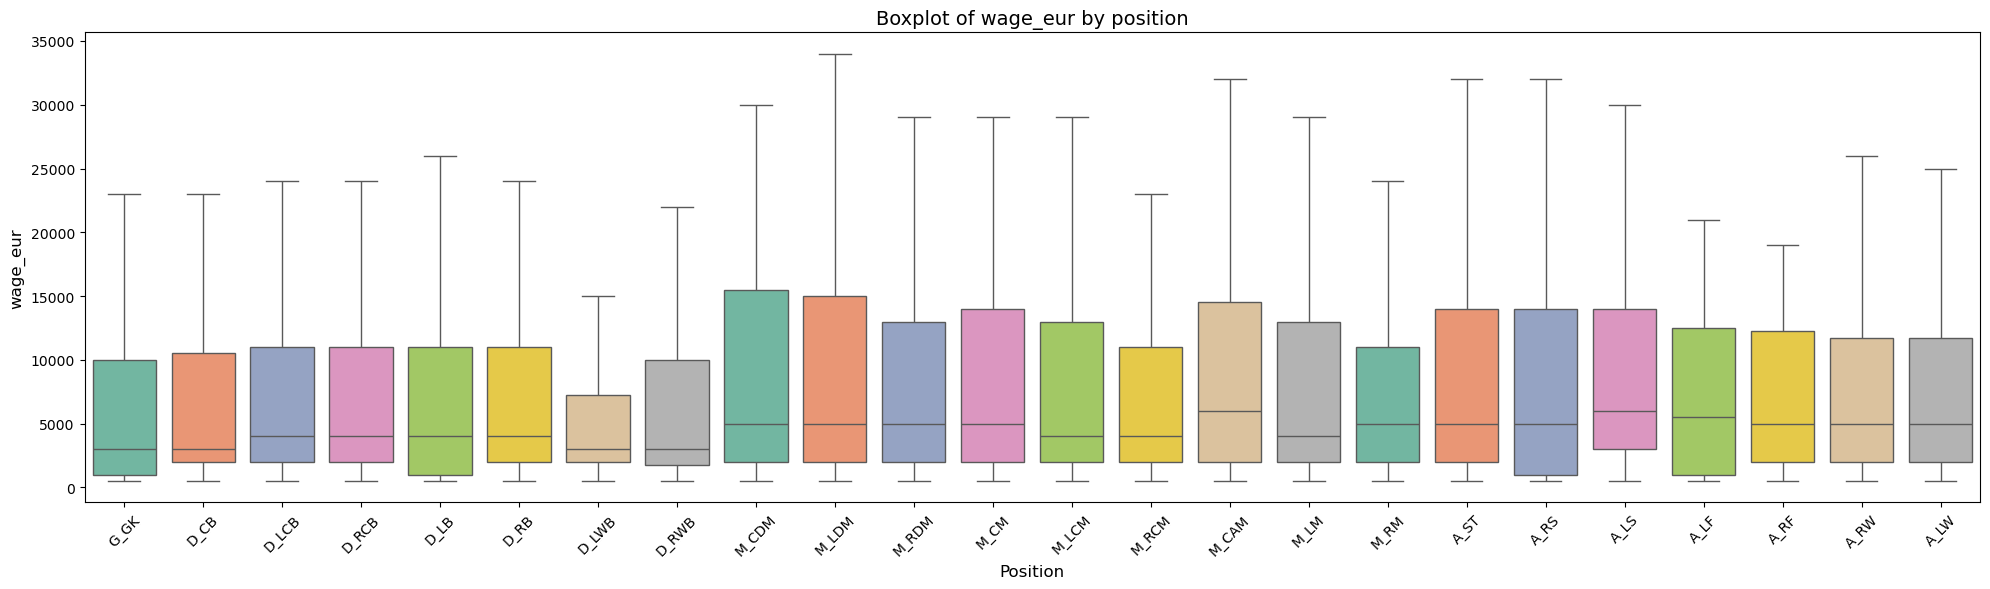

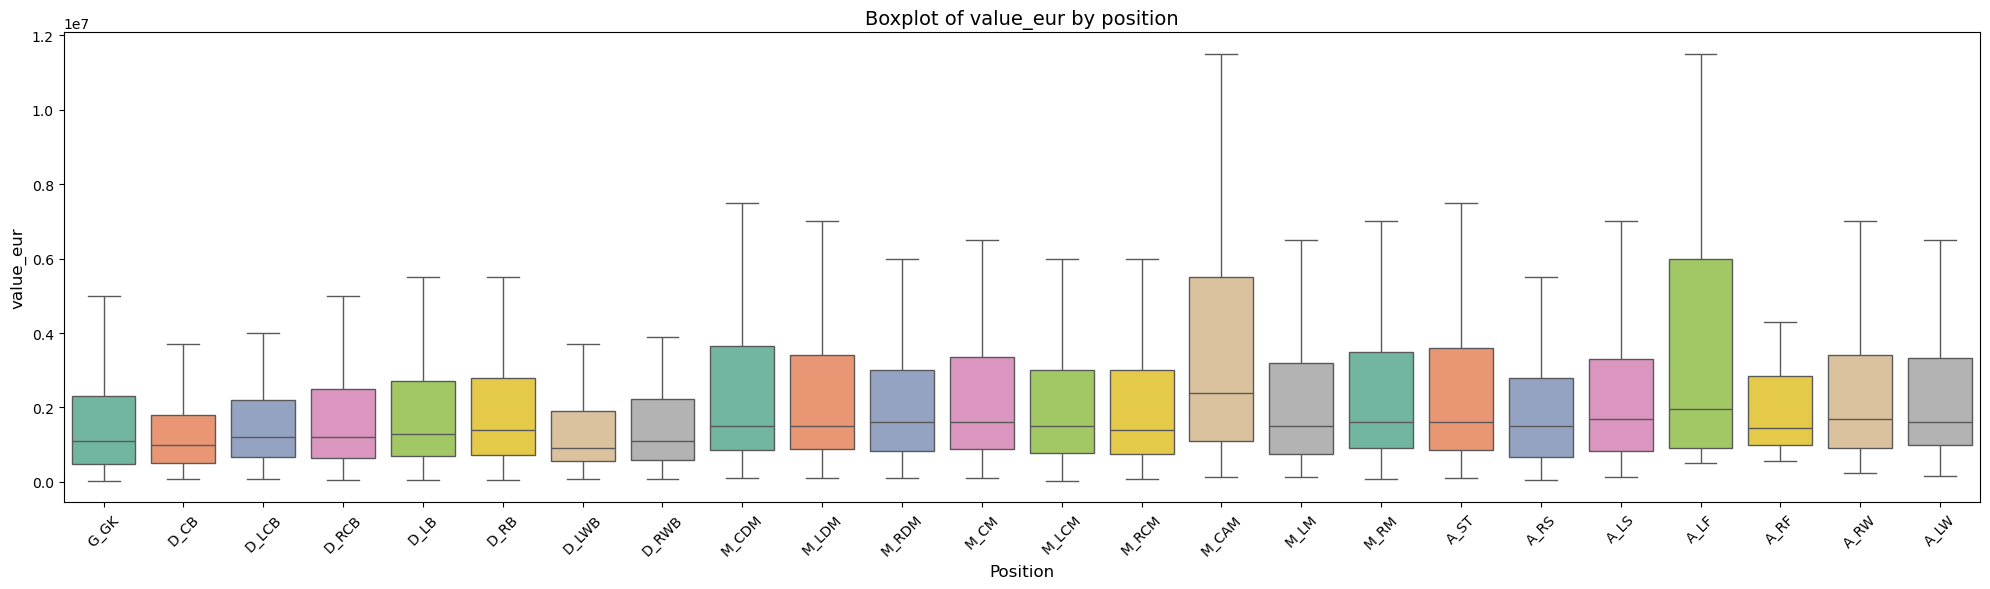

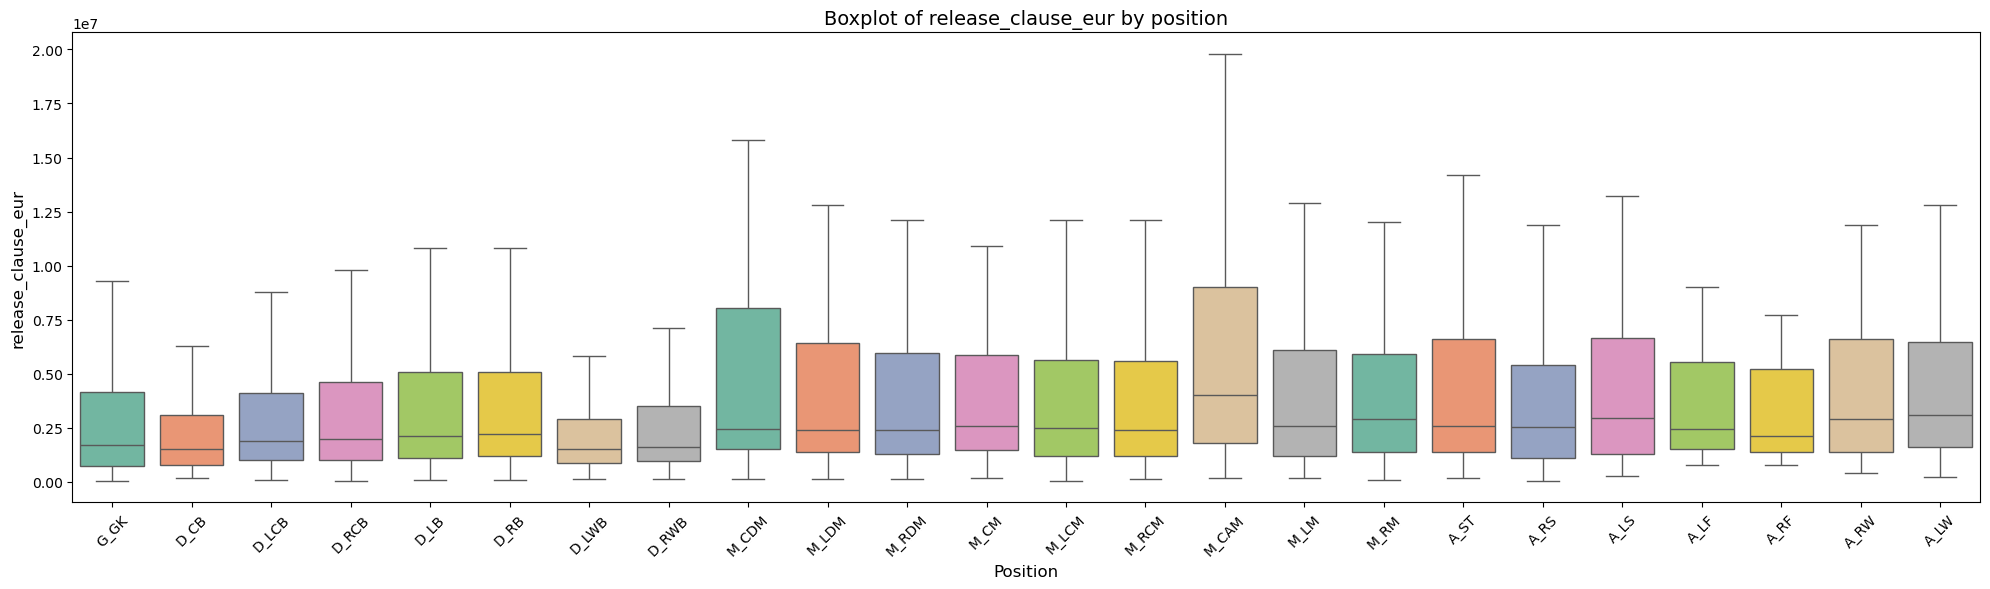

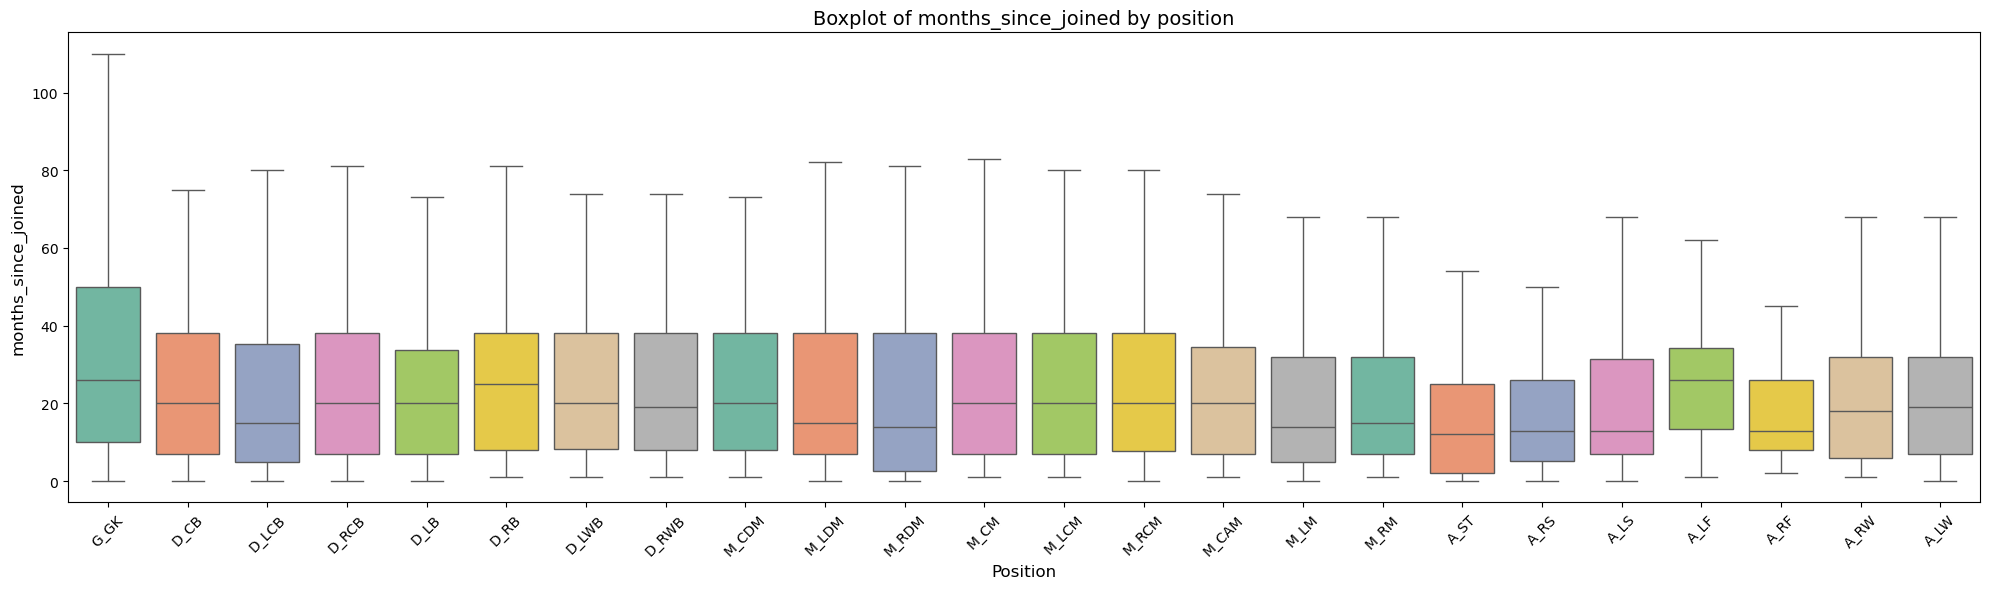

In [65]:
for feature in ['wage_eur', 'value_eur', 'release_clause_eur', 'months_since_joined']:
    plt.figure(figsize=(20, 6))  # Adjust the figure size as needed
    sns.boxplot(data = df_colna, x='position_grouped', y=feature, hue = 'position_grouped', palette="Set2", legend=False, showfliers = False) # We use showfliers = False to exclude outliers
    plt.title(f'Boxplot of {feature} by position', fontsize=14)
    plt.xlabel('Position', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.tight_layout()
    plt.show()

**Relevant insights**:
- *months_since_joined* seems to have a low predictive power, as the boxplots are all very similar for all the positions. Therefore, the best thing to do is to probably drop it.
- On the other hand, *value_eur* and *release_clause_eur* may provide more predictive power: even if medians are relatively similar across different positions, the interquartile ranges are larger for some positions than for others. Consequently, imputation is probably the best approach in this case (either simple imputation or KNN imputation).

In [57]:
# We create copies of the datasets
df_nomonths = df_colna.copy()
dft_nomonths = dft_colna.copy()

# Drop the column months_since_joined
## Training
df_nomonths.drop(columns=['months_since_joined'], inplace=True)
## Test
dft_nomonths.drop(columns=['months_since_joined'], inplace=True)

In [58]:
df_nomonths

,id,short_name,overall,potential,value_eur,wage_eur,height_cm,weight_kg,club_name,league_level,...,real_face_Yes,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium
0,216302,E. García,71,71,1400000.0,10000,176,73,Club Atlético de San Luis,1,...,False,False,False,False,False,False,False,True,False,False
1,237867,D. Cancola,65,71,1000000.0,2000,183,73,Ross County FC,1,...,False,False,False,False,False,False,False,False,False,True
2,253472,E. Kahl,65,77,1600000.0,2000,178,69,Aarhus GF,1,...,False,False,False,True,False,False,False,False,False,False
3,223994,S. Mugoša,72,72,2300000.0,5000,188,81,Incheon United FC,1,...,False,False,False,True,False,False,False,False,False,False
4,251635,A. Țigănașu,65,65,525000.0,3000,179,74,FC Botoşani,1,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6890,242007,C. Whelan,59,66,425000.0,2000,180,65,Carlisle United,4,...,False,False,False,False,False,False,False,False,False,True
6891,187961,Paulinho,83,83,28500000.0,61000,183,80,Al Ahli,1,...,True,True,False,False,False,False,False,False,False,False
6892,257234,Y. Hamache,70,80,3400000.0,6000,177,73,Boavista FC,1,...,False,False,False,True,False,False,False,False,False,False
6893,232511,S. Sasaki,71,71,1300000.0,7000,176,70,Sanfrecce Hiroshima,1,...,False,False,False,False,False,False,False,True,False,False


In [59]:
dft_nomonths

,id,short_name,overall,potential,value_eur,wage_eur,height_cm,weight_kg,club_name,league_level,...,real_face_Yes,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium
0,215562,R. Hunt,63,63,475000.0,3000,171,67,Swindon Town,4,...,False,False,False,True,False,False,False,False,False,False
1,248311,Tiri,64,64,500000.0,950,186,84,ATK Mohun Bagan FC,1,...,False,False,False,False,False,False,False,False,False,True
2,223933,G. Nilsson,64,70,925000.0,2000,197,87,SV Wehen Wiesbaden,3,...,False,False,False,False,False,False,False,False,False,True
3,232546,D. Zabala,72,72,2300000.0,13000,172,64,Rosario Central,1,...,False,False,False,True,False,False,False,False,False,False
4,189217,P. Pawlett,63,63,450000.0,2000,178,68,Dundee United,1,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,205601,C. Atsu,72,72,2300000.0,17000,165,65,Al Raed,1,...,True,False,False,False,False,False,False,False,True,False
763,223752,M. Torres,68,74,1700000.0,2000,180,70,América de Cali,1,...,False,False,False,False,True,False,False,False,False,False
764,192450,A. Cook,65,65,700000.0,6000,185,80,Bradford City,4,...,False,False,False,False,False,True,False,False,False,False
765,192366,N. Otamendi,81,81,12500000.0,18000,183,76,SL Benfica,1,...,True,False,False,False,False,False,False,True,False,False


We have to update the list of feature names with this new feature removal (see the beginning of the notebook).

### 2.4.2. Handling outliers
If outliers are handled, they will be handled after the training-validation split.

In [60]:
# We create a function that checks outliers

def check_outliers(dataframe):

    # Dictionary to hold the outliers information
    outliers_dict = {}

    for column in list(dataframe.columns):

        # For now, we ignore null values by dropping all observations with null values
        series_no_na = dataframe[column].dropna()

        # Calculate quartiles 25% and 75%
        q25, q75 = np.quantile(series_no_na, 0.25), np.quantile(series_no_na, 0.75)

        # Calculate the IQR
        iqr = q75 - q25

        # Calculate the outlier cutoff (in this case, set at 1.5 times the IQR)
        cut_off = iqr * 1.5

        # Calculate the lower and upper bound value
        lower, upper = q25 - cut_off, q75 + cut_off

        # Find the outliers
        outliers = [x for x in series_no_na if (x >= upper) or (x <= lower)]

        # Store the information in a dictionary, where each column will have its
        # own dictionary
        outliers_dict[column] = {
            'IQR': iqr,
            'Minimum': series_no_na.min(),
            'Lower Bound': lower,
            'Median': series_no_na.median(),
            'Upper Bound': upper,
            'Maximum': series_no_na.max(),
            'Outliers': outliers,
            'Num Outliers': len(outliers),
            'Num Observations': series_no_na.shape[0],
            'Percentage Outliers': (len(outliers) * 100)/series_no_na.shape[0]
        }

        # We convert the dictionary into a pandas DataFrame
        df_outliers = pd.DataFrame(outliers_dict)

    return df_outliers

In [64]:
outliers_train = check_outliers(df_nomonths[numerical_features])
outliers_train

,overall,potential,wage_eur,height_cm,weight_kg,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,...,value_eur,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,age,height_weight_ratio
IQR,7.0,8.0,10000.0,9.0,10.0,23.0,31.0,19.0,12.0,28.0,...,2175000.0,4300000.0,15.0,22.0,13.0,12.0,24.0,11.0,6.0,0.215244
Minimum,49,53,500,156,53,7,2,5,7,4,...,25000.0,39000.0,28.0,18.0,25.0,29.0,16.0,31.0,17,1.92233
Lower Bound,54.5,56.0,-13000.0,163.5,55.0,8.5,-13.5,19.5,40.0,-11.0,...,-2537500.0,-5350000.0,39.5,10.0,34.5,41.0,7.0,46.5,15.0,1.983016
Median,68.0,72.0,4000.0,182.0,75.0,58.0,52.0,58.0,65.0,46.0,...,1400000.0,2300000.0,70.0,57.0,60.0,65.0,61.0,69.0,27.0,2.410256
Upper Bound,82.5,88.0,27000.0,199.5,95.0,100.5,110.5,95.5,88.0,101.0,...,6162500.0,11850000.0,99.5,98.0,86.5,89.0,103.0,90.5,39.0,2.843993
Maximum,93,95,350000,203,103,94,95,93,94,90,...,194000000.0,373500000.0,97.0,94.0,93.0,95.0,89.0,90.0,43,3.127273
Outliers,"[83, 54, 85, 85, 85, 87, 83, 86, 88, 84, 83, 5...","[88, 55, 88, 55, 55, 56, 88, 88, 88, 56, 55, 9...","[105000, 31000, 27000, 31000, 38000, 46000, 28...","[163, 163, 160, 162, 163, 160, 203, 163, 156, ...","[95, 95, 95, 99, 98, 95, 53, 103, 95, 95, 96, ...","[8, 7, 8, 8, 7, 8, 8, 8, 8]",[],"[14, 10, 11, 14, 10, 14, 11, 11, 19, 13, 18, 1...","[30, 39, 32, 27, 33, 28, 33, 34, 32, 20, 31, 3...",[],...,"[6500000.0, 30000000.0, 13000000.0, 7500000.0,...","[12200000.0, 57800000.0, 24400000.0, 12500000....","[35.0, 39.0, 31.0, 37.0, 32.0, 31.0, 38.0, 33....",[],"[34.0, 91.0, 91.0, 93.0, 34.0, 29.0, 34.0, 34....","[36.0, 38.0, 34.0, 41.0, 38.0, 41.0, 38.0, 38....",[],"[43.0, 46.0, 43.0, 46.0, 39.0, 45.0, 42.0, 41....","[39, 39, 39, 42, 43, 39, 39, 39, 39, 40, 39, 4...","[2.8793103448275863, 2.9166666666666665, 2.861..."
Num Outliers,178,92,767,36,39,9,0,560,609,0,...,927,878,141,0,28,114,0,94,32,71
Num Observations,6895,6895,6895,6895,6895,6895,6895,6895,6895,6895,...,6893,6542,6264,6264,6264,6264,6264,6264,6895,6895
Percentage Outliers,2.581581,1.3343,11.124003,0.522117,0.565627,0.130529,0.0,8.121827,8.832487,0.0,...,13.448426,13.420972,2.250958,0.0,0.446999,1.819923,0.0,1.500639,0.464104,1.029732


In [ ]:
def detect_outliers_iqr(data, column_name, threshold=1.5):
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    outliers = data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)]

    return outliers

def impute_outliers_with_mean(data, column_name, outliers):
    # Calculate the mean excluding outliers
    filtered_data = data[~data.index.isin(outliers.index)]
    mean_without_outliers = filtered_data[column_name].mean()

    # Impute the mean to the outliers
    data.loc[outliers.index, column_name] = mean_without_outliers

    return data, mean_without_outliers

## 2.5. Saving dataframes
In this step, we export the dataframes to csv so they can be easily imported for other steps in the pipeline. 

In [ ]:
# df_nomonths.to_csv('2_preprocessed_datasets/v1_train.csv', index = False)
# dft_nomonths.to_csv('2_preprocessed_datasets/v1_test.csv', index = False)